In [1]:
# # in google colab uncomment this

# import os

# os.system('apt-get install -y xvfb')
# os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
# os.system('apt-get install -y python-opengl ffmpeg')
# os.system('pip install pyglet==1.2.4')

# os.system('python -m pip install -U pygame --user')

# print('setup complete')

# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

# Implementing Advantage-Actor Critic (A2C)

In this notebook you will implement Advantage Actor Critic algorithm that trains on a batch of Atari 2600 environments running in parallel. 

Firstly, we will use environment wrappers implemented in file `atari_wrappers.py`. These wrappers preprocess observations (resize, grayscal, take max between frames, skip frames and stack them together) and rewards. Some of the wrappers help to reset the environment and pass `done` flag equal to `True` when agent dies.
File `env_batch.py` includes implementation of `ParallelEnvBatch` class that allows to run multiple environments in parallel. To create an environment we can use `nature_dqn_env` function. Note that if you are using 
PyTorch and not using `tensorboardX` you will need to implement a wrapper that will log **raw** total rewards that the *unwrapped* environment returns and redefine the implemention of `nature_dqn_env` function here. 



In [2]:
import numpy as np
from atari_wrappers import nature_dqn_env


N_ENVS = 8
env = nature_dqn_env("SpaceInvadersNoFrameskip-v4", nenvs=N_ENVS)
obs = env.reset()
N_ACTIONS = env.action_space.n
assert obs.shape == (8, 84, 84, 4), obs.shape
assert obs.dtype == np.uint8

Next, we will need to implement a model that predicts logits and values. It is suggested that you use the same model as in [Nature DQN paper](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf) with a modification that instead of having a single output layer, it will have two output layers taking as input the output of the last hidden layer. **Note** that this model is different from the model you used in homework where you implemented DQN. You can use your favorite deep learning framework here. We suggest that you use orthogonal initialization with parameter $\sqrt{2}$ for kernels and initialize biases with zeros. 

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def ortho_weights(shape, scale=1.):
    """ PyTorch port of ortho_init from baselines.a2c.utils """
    shape = tuple(shape)

    if len(shape) == 2:
        flat_shape = shape[1], shape[0]
    elif len(shape) == 4:
        flat_shape = (np.prod(shape[1:]), shape[0])
    else:
        raise NotImplementedError

    a = np.random.normal(0., 1., flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.transpose().copy().reshape(shape)

    if len(shape) == 2:
        return torch.from_numpy((scale * q).astype(np.float32))
    if len(shape) == 4:
        return torch.from_numpy((scale * q[:, :shape[1], :shape[2]]).astype(np.float32))


def atari_initializer(module):
    """ Parameter initializer for Atari models
    Initializes Linear, Conv2d, and LSTM weights.
    """
    classname = module.__class__.__name__

    if classname == 'Linear':
        module.weight.data = ortho_weights(module.weight.data.size(), scale=np.sqrt(2.))
        module.bias.data.zero_()

    elif classname == 'Conv2d':
        module.weight.data = ortho_weights(module.weight.data.size(), scale=np.sqrt(2.))
        module.bias.data.zero_()

    elif classname == 'LSTM':
        for name, param in module.named_parameters():
            if 'weight_ih' in name:
                param.data = ortho_weights(param.data.size(), scale=1.)
            if 'weight_hh' in name:
                param.data = ortho_weights(param.data.size(), scale=1.)
            if 'bias' in name:
                param.data.zero_()


class AtariCNN(nn.Module):
    def __init__(self, num_actions):
        """ Basic convolutional actor-critic network for Atari 2600 games
        Equivalent to the network in the original DQN paper.
        Args:
            num_actions (int): the number of available discrete actions
        """
        super().__init__()

        self.conv = nn.Sequential(nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
                                  nn.ReLU())

        self.fc = nn.Sequential(nn.Linear(64 * 7 * 7, 512),
                                nn.ReLU())

        self.pi = nn.Linear(512, num_actions)
        self.v = nn.Linear(512, 1)

        self.num_actions = num_actions

        # parameter initialization
        self.apply(atari_initializer)
        self.pi.weight.data = ortho_weights(self.pi.weight.size(), scale=.01)
        self.v.weight.data = ortho_weights(self.v.weight.size())

    def forward(self, x):
        """ Module forward pass
        Args:
            x (Variable): convolutional input, shaped [batch_size x 4 x 84 x 84]
        Returns:
            pi (Variable): action probability logits, shaped [batch_size x self.num_actions]
            v (Variable): value predictions, shaped [batch_size x 1]
        """
        batch_size = x.shape[0]
        
        conv_out = self.conv(x).view(batch_size, 64 * 7 * 7)

        fc_out = self.fc(conv_out)

        logits = self.pi(fc_out)
        value = self.v(fc_out)

        return logits, value



You will also need to define and use a policy that wraps the model. While the model computes logits for all actions, the policy will sample actions and also compute their log probabilities.  `policy.act` should return a dictionary of all the arrays that are needed to interact with an environment and train the model.
 Note that actions must be an `np.ndarray` while the other
tensors need to have the type determined by your deep learning framework. 

In [4]:
import gym

class Wrapper(gym.ObservationWrapper):
    def __init(self, env):
        super().__init__(env)
    
    def observation(self, state):
        state = state.transpose(0, 3, 1, 2)
        return torch.tensor(state).float() / 255.0


env = Wrapper(env)
s = env.reset()
print(s.shape)
#s = s.transpose(0, 3, 1, 2)
#s = torch.tensor(s)
model = AtariCNN(N_ACTIONS).to(DEVICE)
logits, values = model(s)
print(logits)
print(values)
torch.distributions.Categorical(logits=logits).sample()

torch.Size([8, 4, 84, 84])
tensor([[-0.0006,  0.0009,  0.0002, -0.0009,  0.0020, -0.0002],
        [-0.0006,  0.0009,  0.0002, -0.0009,  0.0020, -0.0002],
        [-0.0006,  0.0009,  0.0002, -0.0009,  0.0020, -0.0002],
        [-0.0006,  0.0009,  0.0002, -0.0009,  0.0020, -0.0002],
        [-0.0006,  0.0009,  0.0002, -0.0009,  0.0020, -0.0002],
        [-0.0006,  0.0009,  0.0002, -0.0009,  0.0020, -0.0002],
        [-0.0006,  0.0009,  0.0002, -0.0009,  0.0020, -0.0002],
        [-0.0006,  0.0009,  0.0002, -0.0009,  0.0020, -0.0002]],
       grad_fn=<AddmmBackward>)
tensor([[0.0309],
        [0.0309],
        [0.0309],
        [0.0309],
        [0.0309],
        [0.0309],
        [0.0309],
        [0.0309]], grad_fn=<AddmmBackward>)


tensor([5, 3, 5, 4, 0, 0, 4, 0])

In [5]:
a = torch.tensor(np.arange(16))
a = a.reshape(4,4)
print(a)
a[:,3]
actions = torch.tensor([0,1,3,1]).reshape(-1, 1)
print('actions = ', actions)
a.gather(1, actions)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])
actions =  tensor([[0],
        [1],
        [3],
        [1]])


tensor([[ 0],
        [ 5],
        [11],
        [13]])

In [6]:
from torch.nn import functional as F

class Policy:
  def __init__(self, model):
    self.model = model
    
  def act(self, inputs, determ = False):
    logits, values = self.model(inputs)
    dist = torch.distributions.Categorical(logits=logits)

    if determ:
        actions = dist.probs.argmax(dim=1, keepdim=True)
    else:
        actions = dist.sample().view(-1, 1)

    log_probs = F.log_softmax(logits, dim=1)
    action_log_probs = log_probs.gather(1, actions)
    
    #print(actions.shape, logits.shape, action_log_probs.shape, values.shape)

    return {
        'actions': actions.reshape(-1), 
        'logits': logits,
        'log_probs': action_log_probs.reshape(-1), 
        'values': values.reshape(-1)
    }
    #<Implement policy by calling model, sampling actions and computing their log probs>
    # Should return a dict containing keys ['actions', 'logits', 'log_probs', 'values'].

Next will pass the environment and policy to a runner that collects partial trajectories from the environment. 
The class that does is is already implemented for you.

In [7]:
""" RL env runner """
from collections import defaultdict
import numpy as np


class EnvRunner:
  """ Reinforcement learning runner in an environment with given policy """
  def __init__(self, env, policy, nsteps,
               transforms=None, step_var=None):
    self.env = env
    self.policy = policy
    self.nsteps = nsteps
    self.transforms = transforms or []
    self.step_var = step_var if step_var is not None else 0
    self.state = {"latest_observation": self.env.reset()}

  @property
  def nenvs(self):
    """ Returns number of batched envs or `None` if env is not batched """
    return getattr(self.env.unwrapped, "nenvs", None)

  def reset(self):
    """ Resets env and runner states. """
    self.state["latest_observation"] = self.env.reset()

  def get_next(self):
    """ Runs the agent in the environment.  """
    trajectory = defaultdict(list, {"actions": []})
    observations = []
    rewards = []
    resets = []
    self.state["env_steps"] = self.nsteps

    for i in range(self.nsteps):
      observations.append(self.state["latest_observation"])
      act = self.policy.act(self.state["latest_observation"])
      if "actions" not in act:
        raise ValueError("result of policy.act must contain 'actions' "
                         f"but has keys {list(act.keys())}")
      for key, val in act.items():
        trajectory[key].append(val)

      obs, rew, done, _ = self.env.step(trajectory["actions"][-1])
      self.state["latest_observation"] = obs
      rewards.append(rew)
      resets.append(done)
      self.step_var += self.nenvs or 1

      # Only reset if the env is not batched. Batched envs should auto-reset.
      if not self.nenvs and np.all(done):
        self.state["env_steps"] = i + 1
        self.state["latest_observation"] = self.env.reset()

    trajectory.update(observations=observations, rewards=rewards, resets=resets)
    trajectory["state"] = self.state

    for transform in self.transforms:
      transform(trajectory)
    return trajectory


This runner interacts with the environment for a given number of steps and returns a dictionary containing
keys 

* 'observations' 
* 'rewards' 
* 'resets'
* 'actions'
* all other keys that you defined in `Policy`

under each of these keys there is a python `list` of interactions with the environment of specified length $T$ &mdash; the size of partial trajectory. 

To train the part of the model that predicts state values you will need to compute the value targets. 
Any callable could be passed to `EnvRunner` to be applied to each partial trajectory after it is collected. 
Thus, we can implement and use `ComputeValueTargets` callable. 
The formula for the value targets is simple:

$$
\hat v(s_t) = \sum_{t'=0}^{T - 1}\gamma^{t'}r_{t+t'} + \gamma^T \hat{v}(s_{t+T}),
$$

In implementation, however, do not forget to use 
`trajectory['resets']` flags to check if you need to add the value targets at the next step when 
computing value targets for the current step. You can access `trajectory['state']['latest_observation']`
to get last observations in partial trajectory &mdash; $s_{t+T}$.

In [8]:
class ComputeValueTargets:
  def __init__(self, policy, gamma=0.99):
    self.policy = policy
    self.gamma = gamma
    
  def __call__(self, trajectory):
    value_target = policy.act(trajectory['state']['latest_observation'])['values']
    env_steps = trajectory['state']['env_steps']
    rewards = torch.tensor(trajectory['rewards'], dtype=torch.float)
    dones = torch.tensor(trajectory['resets'], dtype=torch.float)
    is_not_done = 1 - dones

    trajectory['value_targets'] = [0] * env_steps
    for i in range(env_steps):
        j = env_steps - i - 1
        value_target = rewards[j] + value_target * self.gamma * is_not_done[j]
        trajectory['value_targets'][j] = value_target


    # This method should modify trajectory inplace by adding 
    # an item with key 'value_targets' to it. 
    #<Compute value targets for a given partial trajectory>

After computing value targets we will transform lists of interactions into tensors
with the first dimension `batch_size` which is equal to `T * nenvs`, i.e. you essentially need
to flatten the first two dimensions. 

In [ ]:
class MergeTimeBatch:
  """ Merges first two axes typically representing time and env batch. """
  def __call__(self, trajectory):
    # Modify trajectory inplace. 
    #<TODO: implement>
    #'actions', 'logits', 'log_probs', 'values', 'observations', 'rewards', 'resets', 'state', 'value_targets'
        
    trajectory['value_targets'] = torch.stack(trajectory['value_targets'])
    trajectory['value_targets'] = trajectory['value_targets'].flatten(0, 1)
    trajectory['values'] = torch.stack(trajectory['values']).flatten(0, 1)
    trajectory['logits'] = torch.stack(trajectory['logits']).flatten(0, 1)
    trajectory['log_probs'] = torch.stack(trajectory['log_probs']).flatten(0, 1)
    
    


In [ ]:
model = AtariCNN(N_ACTIONS)
policy = Policy(model)
runner = EnvRunner(env, policy, nsteps=5,
                   transforms=[ComputeValueTargets(policy),
                               MergeTimeBatch()])

trajectory = runner.get_next()

Now is the time to implement the advantage actor critic algorithm itself. You can look into your lecture,
[Mnih et al. 2016](https://arxiv.org/abs/1602.01783) paper, and [lecture](https://www.youtube.com/watch?v=Tol_jw5hWnI&list=PLkFD6_40KJIxJMR-j5A1mkxK26gh_qg37&index=20) by Sergey Levine.

In [ ]:
import torch.nn as nn

class A2C:
  def __init__(self,
               policy,
               optimizer,
               value_loss_coef=0.25,
               entropy_coef=0.01,
               max_grad_norm=0.5):
    self.policy = policy
    self.optimizer = optimizer
    self.value_loss_coef = value_loss_coef
    self.entropy_coef = entropy_coef
    self.max_grad_norm = max_grad_norm
    
    self.ploss = None
    self.vloss = None
    self.a2c_loss = None
    
    self.vtargets = None
    self.values = None
    self.advantage = None
    self.entropy = None
    
    self.grad_norm = None
    
  def policy_loss(self, trajectory):
    advantage = trajectory['value_targets'] - trajectory['values']
    
    logits = trajectory['logits']
    probs = nn.functional.softmax(logits, dim=-1)
    logprobs = nn.functional.log_softmax(logits, dim=-1)
    
    entropy = -torch.sum(probs * logprobs, dim=-1)

    actor_loss = -torch.mean(trajectory['log_probs'] * advantage.detach()) - self.entropy_coef * torch.mean(entropy)
    
    self.ploss = actor_loss.item()
    self.vtargets = torch.mean(trajectory['value_targets']).item()
    self.values = torch.mean(trajectory['values']).item()
    self.advantage = torch.mean(advantage).item()
    self.entropy = torch.mean(entropy).item()
    
    return actor_loss
 
  def value_loss(self, trajectory):
    critic_loss = torch.mean((trajectory['values'] - trajectory['value_targets'].detach())**2)
    self.vloss = critic_loss.item()
    return critic_loss
    
  def loss(self, trajectory):
    total_loss = self.policy_loss(trajectory) + self.value_loss_coef * self.value_loss(trajectory)
    self.a2c_loss = total_loss.item()
    return total_loss
      
  def step(self, trajectory):
    self.optimizer.zero_grad()
    self.loss(trajectory).backward()
    self.grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), self.max_grad_norm)
    self.optimizer.step()

Now you can train your model. With reasonable hyperparameters training on a single GTX1080 for 10 million steps across all batched environments (which translates to about 5 hours of wall clock time)
it should be possible to achieve *average raw reward over last 100 episodes* (the average is taken over 100 last 
episodes in each environment in the batch) of about 600. You should plot this quantity with respect to 
`runner.step_var` &mdash; the number of interactions with all environments. It is highly 
encouraged to also provide plots of the following quantities (these are useful for debugging as well):

* [Coefficient of Determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) between 
value targets and value predictions
* Entropy of the policy $\pi$
* Value loss
* Policy loss
* Value targets
* Value predictions
* Gradient norm
* Advantages
* A2C loss

For optimization we suggest you use RMSProp with learning rate starting from 7e-4 and linearly decayed to 0, smoothing constant (alpha in PyTorch and decay in TensorFlow) equal to 0.99 and epsilon equal to 1e-5.

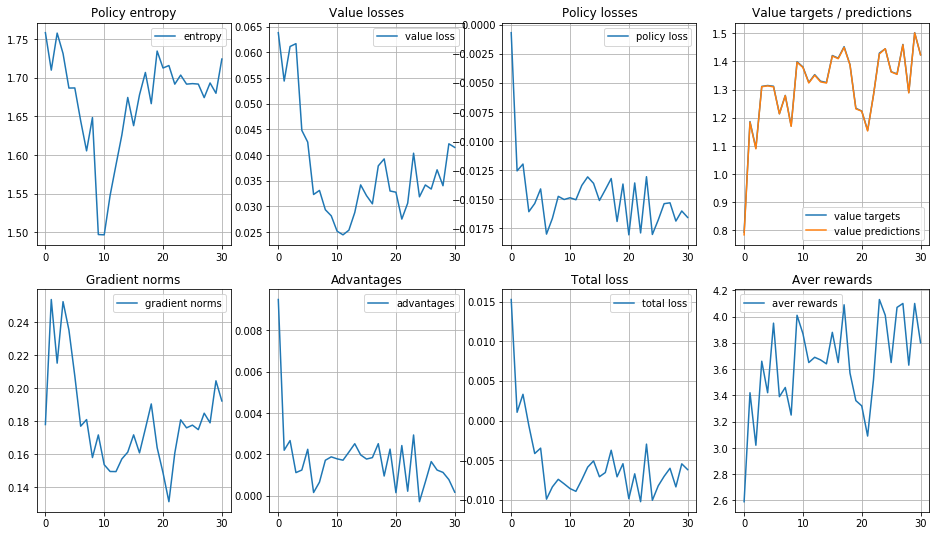

  6%|▋         | 15711/250000 [35:22<9:37:03,  6.77it/s] 

In [ ]:
%matplotlib inline

from tqdm import trange
from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np



agent = AtariCNN(N_ACTIONS)
opt = torch.optim.RMSprop(agent.parameters(), lr=7e-4, alpha=0.99, eps=1e-5)
policy = Policy(agent)
a2c = A2C(policy, opt)
runner = EnvRunner(env, policy, nsteps=5, transforms=[ComputeValueTargets(policy), MergeTimeBatch()])
runner.reset()

entropis = []
mean_entropis = []

vlosses = []
mean_vlosses = []

plosses = []
mean_plosses = []

vtargets = []
mean_vtargets = []

vpredictions = []
mean_vpredictions = []

grad_norms = []
mean_grad_norms = []

advantages = []
mean_advantages = []

a2c_losses = []
mean_a2c_losses = []

mean_rewards = []
rewards = np.zeros(N_ENVS, dtype=float)
dones = np.zeros(N_ENVS, dtype=float)


for i in trange(0, int(1e7), 40):
    trajectory = runner.get_next()
    a2c.step(trajectory)
    
    for batch_rewards, batch_dones in zip(trajectory['rewards'], trajectory['resets']):
        rewards += batch_rewards
        dones += batch_dones
    
    entropis.append(a2c.entropy)
    vlosses.append(a2c.vloss)
    plosses.append(a2c.ploss)
    vtargets.append(a2c.vtargets)
    vpredictions.append(a2c.values)
    grad_norms.append(a2c.grad_norm)
    advantages.append(a2c.advantage)
    a2c_losses.append(a2c.a2c_loss)
        
    if np.sum(dones) >= 100:
        mean_entropis.append(np.mean(entropis))
        mean_vlosses.append(np.mean(vlosses))
        mean_plosses.append(np.mean(plosses))
        mean_vtargets.append(np.mean(vtargets))
        mean_vpredictions.append(np.mean(vpredictions))
        mean_grad_norms.append(np.mean(grad_norms))
        mean_advantages.append(np.mean(advantages))
        mean_a2c_losses.append(np.mean(a2c_losses))

        
        clear_output(True)
        plt.figure(figsize=[16, 9])
        
        plt.subplot(2, 4, 1)
        plt.plot(mean_entropis, label='entropy')
        plt.title("Policy entropy")
        plt.grid()
        plt.legend()
        
        plt.subplot(2, 4, 2)
        plt.plot(mean_vlosses, label='value loss')
        plt.title("Value losses")
        plt.grid()
        plt.legend()
        
        plt.subplot(2, 4, 3)
        plt.plot(mean_plosses, label='policy loss')
        plt.title("Policy losses")
        plt.grid()
        plt.legend()
        
        plt.subplot(2, 4, 4)
        plt.plot(mean_vtargets, label='value targets')
        plt.plot(mean_vpredictions, label='value predictions')
        plt.title("Value targets / predictions")
        plt.grid()
        plt.legend()
        
        plt.subplot(2, 4, 5)
        plt.plot(mean_grad_norms, label='gradient norms')
        plt.title("Gradient norms")
        plt.grid()
        plt.legend()
        
        plt.subplot(2, 4, 6)
        plt.plot(mean_advantages, label='advantages')
        plt.title("Advantages")
        plt.grid()
        plt.legend()
        
        plt.subplot(2, 4, 7)
        plt.plot(mean_a2c_losses, label='total loss')
        plt.title("Total loss")
        plt.grid()
        plt.legend()
        
        plt.subplot(2, 4, 8)
        mean_rewards.append(np.sum(rewards) / np.sum(dones))
        plt.plot(mean_rewards, label='aver rewards')
        plt.title("Aver rewards")
        plt.grid()
        plt.legend()
        
        plt.show()
        
        entropis = []
        vlosses = []
        plosses = []
        vtargets = []
        vpredictions = []
        grad_norms = []
        advantages = []
        a2c_losses = []
        rewards = np.zeros(N_ENVS, dtype=float)
        dones = np.zeros(N_ENVS, dtype=float)

       